<a href="https://colab.research.google.com/github/kovanika/kovanika.github.io/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Кластерный анализ. Оценка групп покупателей средствами кластерного анализа
---



Подключение необходимых библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy.spatial.distance import cityblock
from scipy.spatial import distance
from sklearn.cluster import KMeans
from datetime import datetime
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

# Подготовка данных

Загрузка данных для дальнейшего анализа

In [ ]:
df = pd.read_csv('/content/marketing_campaign.csv', sep='	')

del df["AcceptedCmp3"]
del df["AcceptedCmp4"]
del df["AcceptedCmp5"]
del df["AcceptedCmp1"]
del df["AcceptedCmp2"]
del df["Complain"]
del df["Z_CostContact"]
del df["Z_Revenue"]
del df["Response"]
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,5524,1957,Graduation,Single,58138.0,0,0,04 09 2012,58,635,88,546,172,88,88,3,8,10,4,7
1,2174,1954,Graduation,Single,46344.0,1,1,08 03 2014,38,11,1,6,2,1,6,2,1,1,2,5
2,4141,1965,Graduation,Together,71613.0,0,0,21 08 2013,26,426,49,127,111,21,42,1,8,2,10,4
3,6182,1984,Graduation,Together,26646.0,1,0,10 02 2014,26,11,4,20,10,3,5,2,2,0,4,6
4,5324,1981,PhD,Married,58293.0,1,0,19 01 2014,94,173,43,118,46,27,15,5,5,3,6,5


Типы данных

In [ ]:
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
dtype: object

В первую очередь необходимо удостовериться в отсутствии нулевых строк

In [ ]:
print("Изначальная длина датасета",len(df))
df = df.dropna()
print("Количество непустых строк:", len(df))

Изначальная длина датасета 2240
Количество непустых строк: 2216


Далее необходимо произвести замену текстовых данных на числовые. Для начала необходимо найти уникальные значения в каждом текстовом столбце

In [ ]:
print('Степени обучения: ',df.Education.unique())
print('Семейный статус:',df.Marital_Status.unique())

Степени обучения:  ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
Семейный статус: ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']


Получив число уникальных значений мы можем перевести текстовые значения в числовые

В первую очередь необходимо создать словарь для замены

In [ ]:
cleanup_nums = {"Education":     {"Graduation" : 0, "PhD" : 1,"Master" : 2,"Basic" : 3,"2n Cycle" : 4, },
"Marital_Status":  {"Single" : 0, "Together" : 1, "Married" : 2, "Divorced" : 3, "Widow" : 4, "Alone" : 5, "Absurd" : 6, "YOLO" : 7 }}

После этого мы можем произвести замену

In [ ]:
df = df.replace(cleanup_nums)

Полученный результат

In [ ]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,5524,1957,0,0,58138.0,0,0,04 09 2012,58,635,88,546,172,88,88,3,8,10,4,7
1,2174,1954,0,0,46344.0,1,1,08 03 2014,38,11,1,6,2,1,6,2,1,1,2,5
2,4141,1965,0,1,71613.0,0,0,21 08 2013,26,426,49,127,111,21,42,1,8,2,10,4
3,6182,1984,0,1,26646.0,1,0,10 02 2014,26,11,4,20,10,3,5,2,2,0,4,6
4,5324,1981,1,2,58293.0,1,0,19 01 2014,94,173,43,118,46,27,15,5,5,3,6,5


Переведем дату из типа object в тип datetime64

In [ ]:
df.Dt_Customer = [datetime.strptime(date, "%d %m %Y") for date in df.Dt_Customer]
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,5524,1957,0,0,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7
1,2174,1954,0,0,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5
2,4141,1965,0,1,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4
3,6182,1984,0,1,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6
4,5324,1981,1,2,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5


Произведем вычисление возраста покупателя на момент покупки

In [ ]:
df['Year_Birth'] = pd.to_datetime(df['Year_Birth'],format = '%Y')
df["Age_Cst"] = \
        (df["Dt_Customer"] - df["Year_Birth"]).astype('<m8[Y]')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age_Cst
0,5524,1957-01-01,0,0,58138.0,0,0,2012-09-04,58,635,...,546,172,88,88,3,8,10,4,7,55.0
1,2174,1954-01-01,0,0,46344.0,1,1,2014-03-08,38,11,...,6,2,1,6,2,1,1,2,5,60.0
2,4141,1965-01-01,0,1,71613.0,0,0,2013-08-21,26,426,...,127,111,21,42,1,8,2,10,4,48.0
3,6182,1984-01-01,0,1,26646.0,1,0,2014-02-10,26,11,...,20,10,3,5,2,2,0,4,6,30.0
4,5324,1981-01-01,1,2,58293.0,1,0,2014-01-19,94,173,...,118,46,27,15,5,5,3,6,5,33.0


Так как дата рождения и дата покупки теперь отражены в отдельном столбце, эти столбцы следует удалить из-за невозможности их нормализации. Но делать это лучше в другом датафрейме, чтобы конечная инфографика не пострадала

In [ ]:
df_x = pd.DataFrame(df)
del df_x["ID"]
del df_x["Year_Birth"]
del df_x["Dt_Customer"]
df_x.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age_Cst
0,0,0,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,55.0
1,0,0,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,60.0
2,0,1,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,48.0
3,0,1,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,30.0
4,1,2,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,33.0


Произведя данные операции теперь можно стандартизировать данные

In [ ]:
d = preprocessing.normalize(df_x, axis=0)

df_norm = pd.DataFrame(d, columns=df_x.columns)
df_norm.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age_Cst
0,0.000000,0.000000,0.021296,0.000000,0.000000,0.021646,0.029661,0.039172,0.041485,0.055002,0.038026,0.027513,0.021128,0.034547,0.053619,0.012779,0.025438,0.025503
1,0.000000,0.000000,0.016976,0.030557,0.028606,0.014182,0.000514,0.000445,0.000456,0.000640,0.000432,0.001876,0.014086,0.004318,0.005362,0.006389,0.018170,0.027821
2,0.000000,0.011509,0.026232,0.000000,0.000000,0.009703,0.019899,0.021811,0.009649,0.035495,0.009074,0.013131,0.007043,0.034547,0.010724,0.031947,0.014536,0.022257
3,0.000000,0.011509,0.009761,0.030557,0.000000,0.009703,0.000514,0.001781,0.001520,0.003198,0.001296,0.001563,0.014086,0.008637,0.000000,0.012779,0.021804,0.013911
4,0.013331,0.023017,0.021353,0.030557,0.000000,0.035082,0.008081,0.019141,0.008966,0.014710,0.011667,0.004690,0.035214,0.021592,0.016086,0.019168,0.018170,0.015302


# Анализ данных

# Метод k-means

## Группа на основе всего датасета

Для поиска оптимального количества кластеров воспользуемся методом каменистой осыпи. Минимальное количество кластеров - 1, максимальное 30

In [ ]:
number = range(1,28)
models = [KMeans(n_clusters = k, random_state=42).fit(df_norm) for k in number]
models

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

[KMeans(n_clusters=1, random_state=42),
 KMeans(n_clusters=2, random_state=42),
 KMeans(n_clusters=3, random_state=42),
 KMeans(n_clusters=4, random_state=42),
 KMeans(n_clusters=5, random_state=42),
 KMeans(n_clusters=6, random_state=42),
 KMeans(n_clusters=7, random_state=42),
 KMeans(random_state=42),
 KMeans(n_clusters=9, random_state=42),
 KMeans(n_clusters=10, random_state=42),
 KMeans(n_clusters=11, random_state=42),
 KMeans(n_clusters=12, random_state=42),
 KMeans(n_clusters=13, random_state=42),
 KMeans(n_clusters=14, random_state=42),
 KMeans(n_clusters=15, random_state=42),
 KMeans(n_clusters=16, random_state=42),
 KMeans(n_clusters=17, random_state=42),
 KMeans(n_clusters=18, random_state=42),
 KMeans(n_clusters=19, random_state=42),
 KMeans(n_clusters=20, random_state=42),
 KMeans(n_clusters=21, random_state=42),
 KMeans(n_clusters=22, random_state=42),
 KMeans(n_clusters=23, random_state=42),
 KMeans(n_clusters=24, random_state=42),
 KMeans(n_clusters=25, random_state=42)

Text(0, 0.5, 'y')

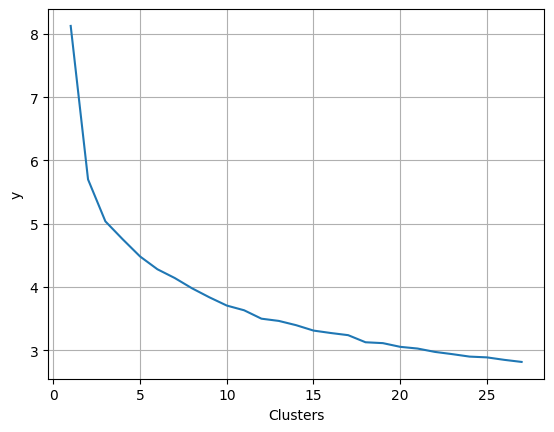

In [ ]:
dist = [model.inertia_ for model in models]
plt.plot(number,dist)
plt.grid()
plt.xlabel("Clusters")
plt.ylabel("y")

Исходя из графика можно сказать о том, что оптимальное количество кластеров равняется 8. Теперь же выведем инфографику о каждом кластере

In [ ]:
model_kmeans = KMeans(n_clusters=2).fit(df_norm)
df['cluster_not_PCA'] = model_kmeans.labels_
df.head()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age_Cst,cluster_not_PCA,cluster_with_PCA
0,5524,1957-01-01,0,0,58138.0,0,0,2012-09-04,58,635,...,88,88,3,8,10,4,7,55.0,1,2
1,2174,1954-01-01,0,0,46344.0,1,1,2014-03-08,38,11,...,1,6,2,1,1,2,5,60.0,0,0
2,4141,1965-01-01,0,1,71613.0,0,0,2013-08-21,26,426,...,21,42,1,8,2,10,4,48.0,1,6
3,6182,1984-01-01,0,1,26646.0,1,0,2014-02-10,26,11,...,3,5,2,2,0,4,6,30.0,0,0
4,5324,1981-01-01,1,2,58293.0,1,0,2014-01-19,94,173,...,27,15,5,5,3,6,5,33.0,0,7


In [ ]:
df_comp_0 = df[['ID', 'Kidhome', 'cluster_not_PCA']]
df_comp_0.head()

,ID,Kidhome,cluster_not_PCA
0,5524,0,1
1,2174,1,0
2,4141,0,1
3,6182,1,0
4,5324,1,0


## Подгруппа (семья, возраст, деньги, дети)

Теперь же можно рассмотреть некоторые подгруппы населения. В первую очередь стоит рассмотреть группу населения относительно их семейного положения, возраста, достатка и количества детей/подростков

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0, 0.5, 'y')

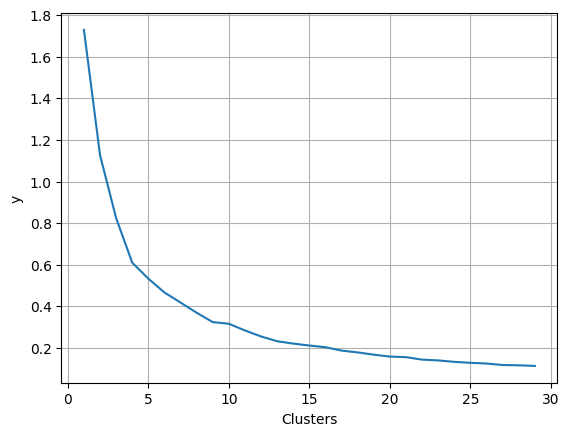

In [ ]:
data=df_norm[['Marital_Status', 'Age_Cst', 'Income', 'Kidhome', 'Teenhome']]
number = range(1,30)
models = [KMeans(n_clusters = k, random_state=42).fit(data) for k in number]
models
dist = [model.inertia_ for model in models]
plt.plot(number,dist)
plt.grid()
plt.xlabel("Clusters")
plt.ylabel("y")

Приведем соответствие каждого покупателя к какому-либо кластеру

In [ ]:
model_kmeans = KMeans(n_clusters=4).fit(data)
data=df[['Marital_Status', 'Age_Cst', 'Income', 'Kidhome', 'Teenhome']]
data['cluster'] = model_kmeans.labels_
data.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-94-a50d5cca82e3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster'] = model_kmeans.labels_


,Marital_Status,Age_Cst,Income,Kidhome,Teenhome,cluster
0,0,55.0,58138.0,0,0,1
1,0,60.0,46344.0,1,1,0
2,1,48.0,71613.0,0,0,1
3,1,30.0,26646.0,1,0,0
4,2,33.0,58293.0,1,0,1


In [ ]:
df_comp_1 = data[['Income', 'cluster']]
df_comp_1.head()

,Income,cluster
0,58138.0,1
1,46344.0,0
2,71613.0,1
3,26646.0,0
4,58293.0,1


## Подгруппа продукты

Также можно провести кластеризацию исходя из покупаемых товаров


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0, 0.5, 'y')

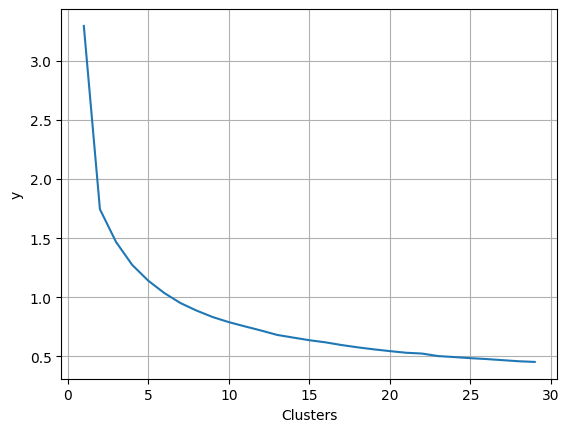

In [ ]:
data=df_norm[['MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']]
number = range(1,30)
models = [KMeans(n_clusters = k, random_state=42).fit(data) for k in number]
models
dist = [model.inertia_ for model in models]
plt.plot(number,dist)
plt.grid()
plt.xlabel("Clusters")
plt.ylabel("y")

Приведем соответствие каждого покупателя к какому-либо кластеру

In [ ]:
model_kmeans = KMeans(n_clusters=2).fit(data)
data=df[['MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']]
data['cluster'] = model_kmeans.labels_
data.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-98-1bdd3df82e11>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster'] = model_kmeans.labels_


,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,cluster
0,88,546,172,88,88,1
1,1,6,2,1,6,0
2,49,127,111,21,42,1
3,4,20,10,3,5,0
4,43,118,46,27,15,1


In [ ]:
df_comp_2 = data[['MntMeatProducts','MntFishProducts', 'cluster']]
df_comp_2.head()

,MntMeatProducts,MntFishProducts,cluster
0,546,172,1
1,6,2,0
2,127,111,1
3,20,10,0
4,118,46,1


## Подгруппа (место покупки)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0, 0.5, 'y')

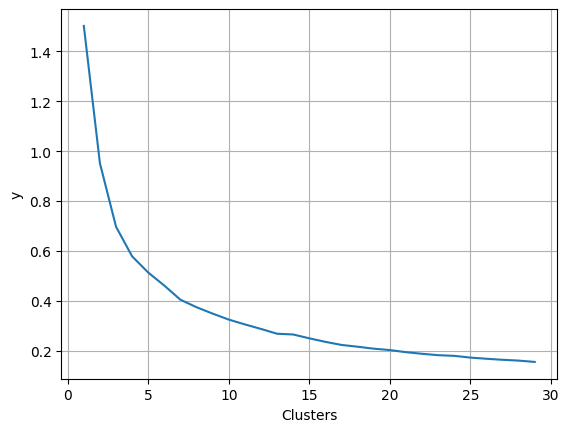

In [ ]:
data=df_norm[['NumDealsPurchases',	'NumWebPurchases',	'NumCatalogPurchases',	'NumStorePurchases']]
number = range(1,30)
models = [KMeans(n_clusters = k, random_state=42).fit(data) for k in number]
models
dist = [model.inertia_ for model in models]
plt.plot(number,dist)
plt.grid()
plt.xlabel("Clusters")
plt.ylabel("y")

In [ ]:
model_kmeans = KMeans(n_clusters=4).fit(data)
data=df[['NumDealsPurchases',	'NumWebPurchases',	'NumCatalogPurchases',	'NumStorePurchases']]
data['cluster'] = model_kmeans.labels_
data.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-64-ed8dd54cfe25>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster'] = model_kmeans.labels_


,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,cluster
0,3,8,10,4,0
1,2,1,1,2,1
2,1,8,2,10,3
3,2,2,0,4,1
4,5,5,3,6,2


# Метод главных компонент (PCA)

## Уменьшение размерности методом главных компонент

### Метод локтя для оптимизации поиска числа компонент

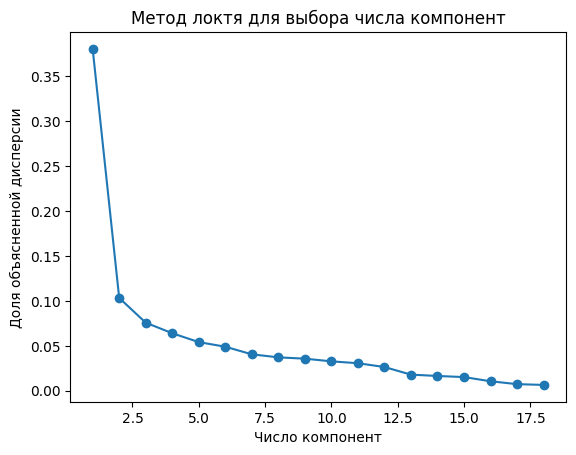

In [ ]:
pca = PCA()

pca.fit_transform(df_norm)


explained_variance_ratio = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel("Число компонент")
plt.ylabel("Доля объясненной дисперсии")
plt.title("Метод локтя для выбора числа компонент")
plt.show()

Таким образом, оптимальное количество компонент - 2

In [ ]:
pca = PCA(n_components=2).fit_transform(df_norm)
df_PCA = pd.DataFrame(pca)
df_PCA.head()

,0,1
0,0.073357,-0.009088
1,-0.036942,0.000686
2,0.023452,-0.006304
3,-0.034590,-0.016936
4,-0.004831,-0.006861


## Кластеризация методом k-средних

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0, 0.5, 'y')

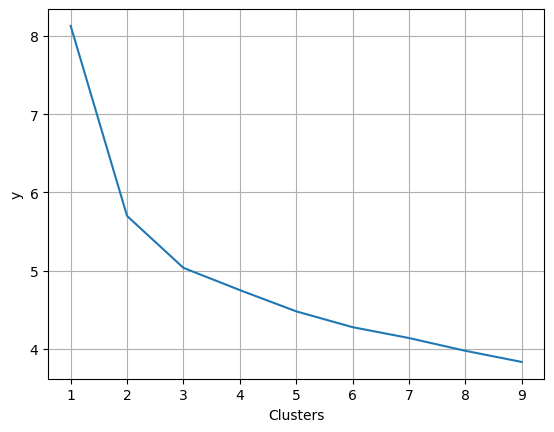

In [ ]:
number = range(1,10)
models = [KMeans(n_clusters = k, random_state=42).fit(df_norm) for k in number]
models
dist = [model.inertia_ for model in models]
plt.plot(number,dist)
plt.grid()
plt.xlabel("Clusters")
plt.ylabel("y")


In [ ]:
model_kmeans = KMeans(n_clusters=2).fit(df_norm)
df_PCA=df
df['cluster_with_PCA'] = model_kmeans.labels_
df

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age_Cst,cluster_not_PCA,cluster_with_PCA
0,5524,1957-01-01,0,0,58138.0,0,0,2012-09-04,58,635,...,88,88,3,8,10,4,7,55.0,1,0
1,2174,1954-01-01,0,0,46344.0,1,1,2014-03-08,38,11,...,1,6,2,1,1,2,5,60.0,0,1
2,4141,1965-01-01,0,1,71613.0,0,0,2013-08-21,26,426,...,21,42,1,8,2,10,4,48.0,1,0
3,6182,1984-01-01,0,1,26646.0,1,0,2014-02-10,26,11,...,3,5,2,2,0,4,6,30.0,0,1
4,5324,1981-01-01,1,2,58293.0,1,0,2014-01-19,94,173,...,27,15,5,5,3,6,5,33.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967-01-01,0,2,61223.0,0,1,2013-06-13,46,709,...,118,247,2,9,3,4,5,46.0,1,0
2236,4001,1946-01-01,1,1,64014.0,2,1,2014-06-10,56,406,...,0,8,7,8,2,5,7,68.0,0,1
2237,7270,1981-01-01,0,3,56981.0,0,0,2014-01-25,91,908,...,12,24,1,2,3,13,6,33.0,1,0
2238,8235,1956-01-01,2,1,69245.0,0,1,2014-01-24,8,428,...,30,61,2,6,5,10,3,58.0,1,0


## Сравнение с k-means без снижения размерности

Для сравнения посчитаем количество совпавших значений кластеров. Необходимо создать компаратор и посчитать количество совпадений

In [ ]:
df_comp = df[['cluster_not_PCA','cluster_with_PCA']]
df_comp.head()

,cluster_not_PCA,cluster_with_PCA
0,1,0
1,0,1
2,1,0
3,0,1
4,0,1


In [ ]:
df_comp['compare'] = df['cluster_not_PCA'] !=  df['cluster_with_PCA']
df_comp

,cluster_not_PCA,cluster_with_PCA,compare
0,1,0,True
1,0,1,True
2,1,0,True
3,0,1,True
4,0,1,True
...,...,...,...
2235,1,0,True
2236,0,1,True
2237,1,0,True
2238,1,0,True


In [ ]:
sum = np.array([0] * df_comp['cluster_not_PCA'].nunique())
df_comp = df_comp.astype(int)
np_array = df_comp.values
df_comp
for i in range(df_comp['cluster_not_PCA'].nunique()):
  for j in range(len(np_array)):
      if np_array[j][0] == i:
        sum[i] += 1
sum.T.sort()
sum_1 = np.array([0] * df_comp['cluster_with_PCA'].nunique())
df_comp = df_comp.astype(int)
np_array = df_comp.values
df_comp
for i in range(df_comp['cluster_with_PCA'].nunique()):
  for j in range(len(np_array)):
      if np_array[j][1] == i:
        sum_1[i] += 1
sum_1.T.sort()
print('cluster_not_PCA: ',sum)
print('cluster_with_PCA: ',sum_1)
print('MSE',mean_squared_error(sum, sum_1, squared=False))

cluster_not_PCA:  [ 801 1415]
cluster_with_PCA:  [ 801 1415]
MSE 0.0


Основываясь на полученных результатах, мы можем сказать о том, что метод главных компонент позволяет уменьшить размерность данных без потери точности

# Иерархическая кластеризация

Пространство: Евклидово Метод: Ближайшего соседа

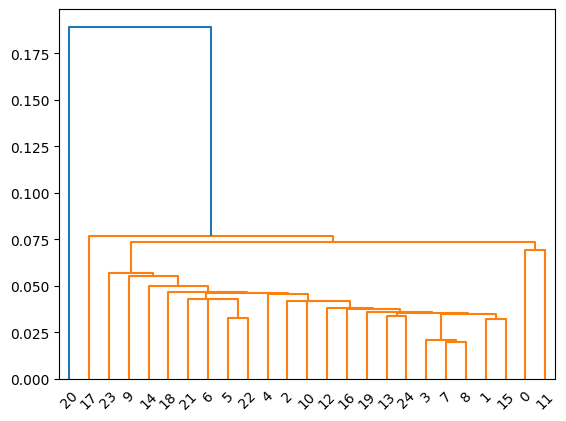

In [ ]:
link_0=linkage(df_norm[:25],method = 'single', metric = 'euclidean')
dn=dendrogram(link_0, orientation= 'top')

In [ ]:
df_ln_1 = pd.DataFrame(link_0, columns = [['№ первого кластера','№ второго кластера','Расстояние между кластерами', 'Стран в кластере']])
df_ln_1

,№ первого кластера,№ второго кластера,Расстояние между кластерами,Стран в кластере
0,7.0,8.0,0.019584,2.0
1,3.0,25.0,0.020997,3.0
2,1.0,15.0,0.032278,2.0
3,5.0,22.0,0.032838,2.0
4,13.0,24.0,0.033726,2.0
5,26.0,27.0,0.034842,5.0
6,29.0,30.0,0.035453,7.0
7,19.0,31.0,0.035866,8.0
8,16.0,32.0,0.037676,9.0
9,12.0,33.0,0.038171,10.0


In [ ]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single')
df_c1 = df[:25]
del df_c1['cluster_not_PCA']
del df_c1['cluster_with_PCA']
cluster.fit_predict(df_norm[:25])
df_c1['clusters'] = cluster.labels_
df_c1

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
<ipython-input-126-dedc60109a5e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c1['clusters'] = cluster.labels_


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age_Cst,clusters
0,5524,1957-01-01,0,0,58138.0,0,0,2012-09-04,58,635,...,172,88,88,3,8,10,4,7,55.0,0
1,2174,1954-01-01,0,0,46344.0,1,1,2014-03-08,38,11,...,2,1,6,2,1,1,2,5,60.0,0
2,4141,1965-01-01,0,1,71613.0,0,0,2013-08-21,26,426,...,111,21,42,1,8,2,10,4,48.0,0
3,6182,1984-01-01,0,1,26646.0,1,0,2014-02-10,26,11,...,10,3,5,2,2,0,4,6,30.0,0
4,5324,1981-01-01,1,2,58293.0,1,0,2014-01-19,94,173,...,46,27,15,5,5,3,6,5,33.0,0
5,7446,1967-01-01,2,1,62513.0,0,1,2013-09-09,16,520,...,0,42,14,2,6,4,10,6,46.0,0
6,965,1971-01-01,0,3,55635.0,0,1,2012-11-13,34,235,...,50,49,27,4,7,3,7,6,41.0,0
7,6177,1985-01-01,1,2,33454.0,1,0,2013-05-08,32,76,...,3,1,23,2,4,0,4,8,28.0,0
8,4855,1974-01-01,1,1,30351.0,1,0,2013-06-06,19,14,...,3,3,2,1,3,0,2,9,39.0,0
9,5899,1950-01-01,1,1,5648.0,1,1,2014-03-13,68,28,...,1,1,13,1,1,0,0,20,64.0,0


Пространство: Евклидово Метод: Дальнего соседа

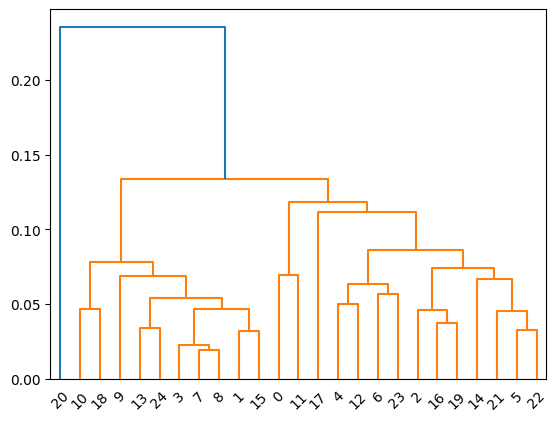

In [ ]:
link_1=linkage(df_norm[:25], method = 'complete', metric = 'euclidean')
dn=dendrogram(link_1, orientation= 'top')

In [ ]:
df_ln_2 = pd.DataFrame(link_1, columns = [['№ первого кластера','№ второго кластера','Расстояние между кластерами', 'Стран в кластере']])
df_ln_2

,№ первого кластера,№ второго кластера,Расстояние между кластерами,Стран в кластере
0,7.0,8.0,0.019584,2.0
1,3.0,25.0,0.022604,3.0
2,1.0,15.0,0.032278,2.0
3,5.0,22.0,0.032838,2.0
4,13.0,24.0,0.033726,2.0
5,16.0,19.0,0.037676,2.0
6,21.0,28.0,0.045461,3.0
7,2.0,30.0,0.045861,3.0
8,10.0,18.0,0.046607,2.0
9,26.0,27.0,0.046879,5.0


In [ ]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
df_c2 = df[:25]
del df_c2['cluster_not_PCA']
del df_c2['cluster_with_PCA']
cluster.fit_predict(df_norm[:25])
df_c2['clusters'] = cluster.labels_
df_print_2 = df_c2[['ID','Income','clusters']]
df_print_2[20:]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
<ipython-input-138-ca11c3f3f795>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c2['clusters'] = cluster.labels_


,ID,Income,clusters
21,5376,2447.0,1
22,1993,58607.0,0
23,4047,65324.0,0
24,1409,40689.0,0
25,7892,18589.0,0


Манхэттенское расстояние. Метод дальнего соседа

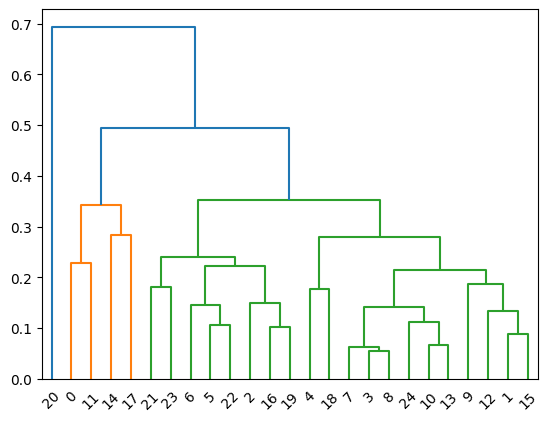

In [ ]:
link_3=linkage(df_norm[:25], metric=distance.cityblock, method='complete')
dn=dendrogram(link_3, orientation= 'top')

In [ ]:
df_ln_3 = pd.DataFrame(link_3, columns = [['№ первого кластера','№ второго кластера','Расстояние между кластерами', 'Стран в кластере']])
df_ln_3

,№ первого кластера,№ второго кластера,Расстояние между кластерами,Стран в кластере
0,3.0,8.0,0.055527,2.0
1,7.0,25.0,0.063577,3.0
2,10.0,13.0,0.067372,2.0
3,1.0,15.0,0.088177,2.0
4,16.0,19.0,0.103014,2.0
5,5.0,22.0,0.105764,2.0
6,24.0,27.0,0.111392,3.0
7,12.0,28.0,0.132804,3.0
8,26.0,31.0,0.141882,6.0
9,6.0,30.0,0.146228,3.0


In [ ]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='manhattan', linkage='complete')
df_c3 = df[:25]
del df_c3['cluster_not_PCA']
del df_c3['cluster_with_PCA']
cluster.fit_predict(df_norm[:25])
df_c3['clusters'] = cluster.labels_
df_print_3 = df_c3[['ID','Income','clusters']]
df_print_3[20:]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
<ipython-input-137-66d718f4d663>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c3['clusters'] = cluster.labels_


,ID,Income,clusters
21,5376,2447.0,1
22,1993,58607.0,0
23,4047,65324.0,0
24,1409,40689.0,0
25,7892,18589.0,0
